In [1]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time)

Starting Time = 15:28:06


Import Required Libraries:

In [2]:
# pip install tensorflow-gpu

Set Numpy, Python and Tensorflow seeds to get consistent results.

In [3]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model



In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16110487470400760164
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914477671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5002396166897971276
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


**Step 1: Download and Extract the Dataset**

In [8]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**Step 2: Visualize the Data with its Labels**

In [9]:
# !wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
# !unrar x UCF50.rar -inul -y


In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# os.getcwd()
# os.chdir(r"/content/drive/MyDrive/ML/")
# os.getcwd()

In [12]:
os.getcwd()

'z:\\ML\\CourseProject'

In [13]:
os.listdir()

['.ipynb_checkpoints',
 'Classification',
 'model_structure_plot.png',
 'Model___Date_Time_2021_12_19__14_36_20___Loss_1.1215968132019043___Accuracy_0.7099999785423279.h5',
 'Model___Date_Time_2021_12_19__16_36_27___Loss_0.03579356521368027___Accuracy_0.9909999966621399.h5',
 'Model___Date_Time_2021_12_20__15_16_49___Loss_0.04868216812610626___Accuracy_0.9850000143051147.h5',
 'run.ipynb',
 'Videos',
 'z_2gpu.ipynb',
 'z_gpu.ipynb',
 '__temp__.mp4',
 '__temp__TEMP_MPY_wvf_snd.mp3']

**Step 3: Read and Preprocess the Dataset**

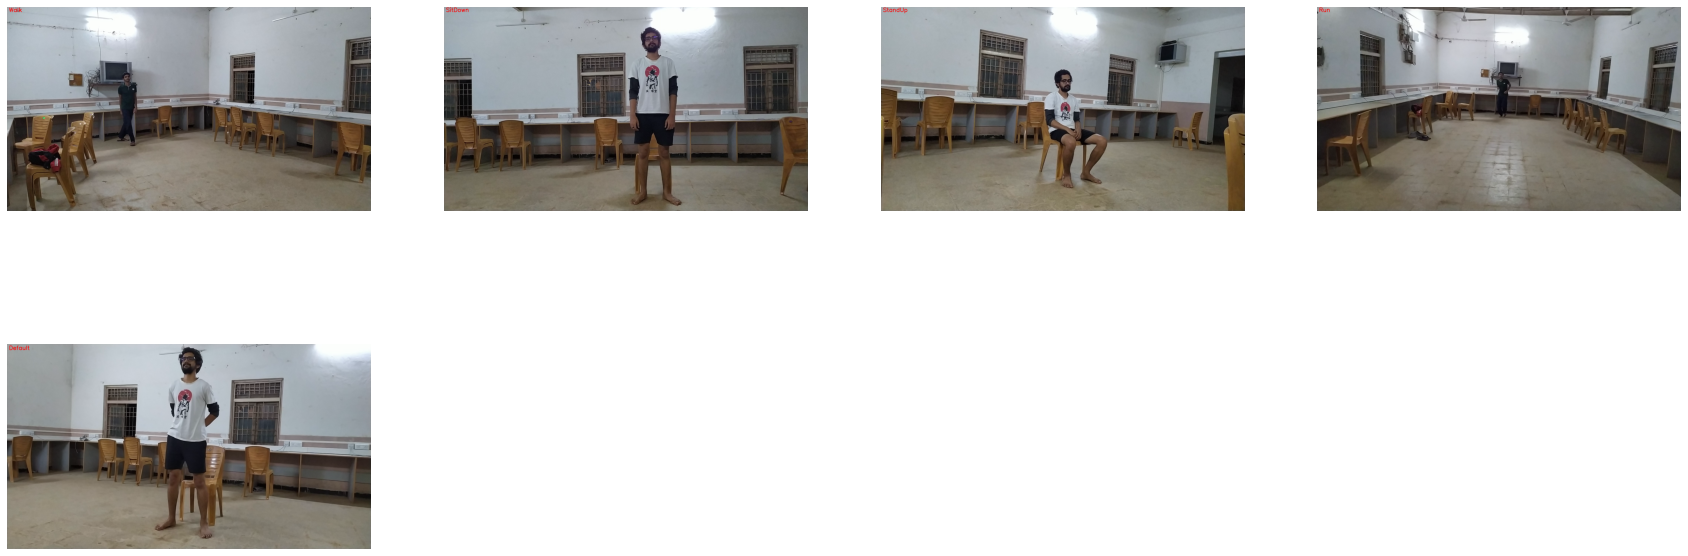

In [14]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('Classification')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 5)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'Classification/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'Classification/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')


In [15]:
image_height, image_width = 64, 64
max_images_per_class = 1000

dataset_directory = "Classification"
classes_list = ["Run", "SitDown", "StandUp", "Walk", "Default"]

model_output_size = len(classes_list)


Extract, Resize and Normalize Frames

In [16]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list


Dataset Creation

In [17]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels
features, labels = create_dataset()



Extracting Data of Class: Run
Extracting Data of Class: SitDown
Extracting Data of Class: StandUp
Extracting Data of Class: Walk
Extracting Data of Class: Default


In [18]:
features, labels = create_dataset()

Extracting Data of Class: Run
Extracting Data of Class: SitDown
Extracting Data of Class: StandUp
Extracting Data of Class: Walk
Extracting Data of Class: Default


In [19]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

**Step 4: Split the Data into Train and Test Sets**

In [20]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)


**Step 5: Construct the Model**

In [21]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

Check Model’s Structure:

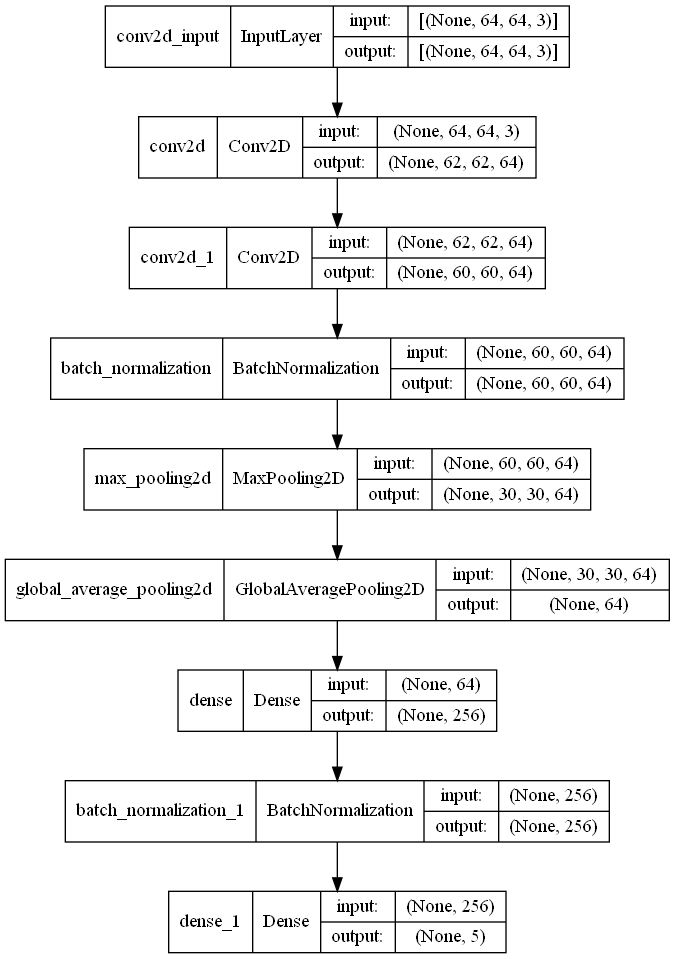

In [22]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Step 6: Compile and Train the Model**

In [23]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/50
800/800 [==============================] - 10s 8ms/step - loss: 1.0047 - accuracy: 0.6034 - val_loss: 6.2224 - val_accuracy: 0.2050
Epoch 2/50
800/800 [==============================] - 7s 9ms/step - loss: 0.5675 - accuracy: 0.7987 - val_loss: 15.8328 - val_accuracy: 0.1988
Epoch 3/50
800/800 [==============================] - 7s 9ms/step - loss: 0.4073 - accuracy: 0.8559 - val_loss: 17.4674 - val_accuracy: 0.3950
Epoch 4/50
800/800 [==============================] - 7s 9ms/step - loss: 0.3332 - accuracy: 0.8844 - val_loss: 3.5384 - val_accuracy: 0.6587
Epoch 5/50
800/800 [==============================] - 7s 9ms/step - loss: 0.2845 - accuracy: 0.9087 - val_loss: 2.2461 - val_accuracy: 0.3550
Epoch 6/50
800/800 [==============================] - 7s 9ms/step - loss: 0.2274 - accuracy: 0.9241 - val_loss: 3.8686 - val_accuracy: 0.2725
Epoch 7/50
800/800 [==============================] - 7s 9ms/step - loss: 0.2070 - accuracy: 0.9275 - val_loss: 1.6276 - val_accuracy: 0.6913
Epo

Evaluating Your Trained Model

In [24]:
model_evaluation_history = model.evaluate(features_test, labels_test)


32/32 [==============================] - 1s 15ms/step - loss: 0.0627 - accuracy: 0.9820


Save Your Model

In [25]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)


**Step 7: Plot Model’s Loss and Accuracy Curves**

In [26]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()


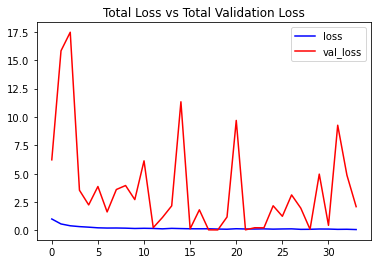

In [27]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')


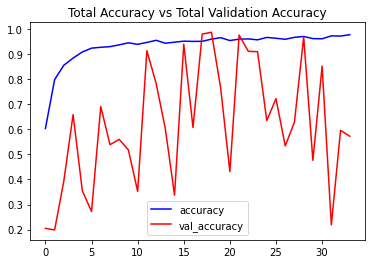

In [28]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


**Step 8: Make Predictions with the Model:**

Function To Predict on Live Videos Using Moving Average:

In [29]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()


In [30]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()


Test Average Prediction Method On Videos:

In [31]:
output_directory="Videos"
video_title="test"

# Constructing The Input YouTube Video Path
# input_video_file_path = f'./{output_directory}/{video_title}.mp4'

input_video_file_path = f'Z:/ML/CourseProject/Videos/15.mp4'
# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)


CLASS NAME: Run   AVERAGED PROBABILITY: 1e+02
CLASS NAME: Walk   AVERAGED PROBABILITY: 0.00011
CLASS NAME: Default   AVERAGED PROBABILITY: 8e-05
CLASS NAME: SitDown   AVERAGED PROBABILITY: 3e-05
CLASS NAME: StandUp   AVERAGED PROBABILITY: 3e-07


In [32]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Termination Time =", current_time)

Termination Time = 15:36:04
